In [5]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.optimize

from sublimpy import tidy


import altair as alt
alt.data_transformers.enable('json') 
import matplotlib.pyplot as plt

import xarray as xr

import pint_xarray
from metpy.calc import specific_humidity_from_mixing_ratio
from metpy.units import units

And now estimate the full profile for a range $z$ between 0 and 3 m

In [ ]:
def get_T_z_ground(z):
    z = z * units("meters")
    return (T_s_ground + (
        H_ground / (-k*rho*c_p*U_star_ground)
    ) * np.log(
        z / z_0
    )).to(units("degC")).magnitude

# Inputs

In [15]:
start_date = '20221130'
end_date = '20230517'
sos_download_dir = '/data2/elilouis/sublimationofsnow/sosnoqc'

In [16]:
try:
    tidy_df_5Min = pd.read_parquet(f"../sos/tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])

# M.O.S.T. Solutions

## Extract variables, make necessary conversions, and create measurement height variable

In [17]:
# EXTRACT VARIABLES
VARIABLES = [
    ## Input Variables
    'spd_3m_c',
    'spd_5m_c',
    'Tpot_3m_c',
    'Tpot_5m_c',
    'Tsurfpot_c',
    'airdensity_3m_c',
    'mixingratio_3m_c',
    'mixingratio_5m_c',
    'Tsurfmixingratio_c',
    'T_3m_c',
    ## Measurement Variables
    'w_h2o__3m_c',
    'w_h2o__5m_c',
    'w_tc__3m_c',
    'u*_3m_c',
    'Ri_3m_c',
    ## Input Variables for Turbpy
    'Tsurf_c',
    'P_10m_c',
]
print([ v for v in tidy_df_5Min.variable.unique() if v in VARIABLES ])

# CREATE DATAFRAME
variables_df = tidy_df_5Min[tidy_df_5Min.variable.isin(VARIABLES)].pivot_table(
    values = 'value',
    index = 'time',
    columns='variable'
).reset_index()

# MAKE CONVERSIONS
# convert from ˚C to K
variables_df['T_3m_c'] = variables_df['T_3m_c'] + 273.15
variables_df['T_5m_c'] = variables_df['T_3m_c'] + 273.15
variables_df['Tpot_3m_c'] = variables_df['Tpot_3m_c'] + 273.15
variables_df['Tpot_5m_c'] = variables_df['Tpot_3m_c'] + 273.15
variables_df['Tsurfpot_c'] = variables_df['Tsurfpot_c'] + 273.15
variables_df['Tsurf_c'] = variables_df['Tsurf_c']  + 273.15
# comes in units of g/g
variables_df['specifichumidity_3m_c'] = specific_humidity_from_mixing_ratio(
    xr.DataArray(variables_df['mixingratio_3m_c'])*units('g/g')
).pint.to('g/kg').values
variables_df['specifichumidity_5m_c'] = specific_humidity_from_mixing_ratio(
    xr.DataArray(variables_df['mixingratio_5m_c'])*units('g/g')
).pint.to('g/kg').values

# comes in units of g/g
# our solution requires it in units of g/kg
variables_df['specifichumidity_surface_c'] = specific_humidity_from_mixing_ratio(
    xr.DataArray(variables_df['Tsurfmixingratio_c'])*units('g/g')
).pint.to('g/kg').values

# CREATE MEASUREMENT HEIGHT VARIABLES
variables_df['measurement_height'] = 3
variables_df['measurement_height'] = 3
variables_df['measurement_height'] = 3

variables_df['measurement_height_2'] = 5
variables_df['measurement_height_2'] = 5
variables_df['measurement_height_2'] = 5

['airdensity_3m_c', 'Tsurfmixingratio_c', 'mixingratio_3m_c', 'mixingratio_5m_c', 'Tpot_3m_c', 'Tpot_5m_c', 'P_10m_c', 'Ri_3m_c', 'u*_3m_c', 'Tsurfpot_c', 'Tsurf_c', 'T_3m_c', 'w_h2o__3m_c', 'w_h2o__5m_c', 'w_tc__3m_c', 'spd_3m_c', 'spd_5m_c']


## Use MOST solver class

In [18]:
from most import MOST, MOSTMulti, StabilityFunctionBrutsaert1982
my_most = MOST(
    StabilityFunctionBrutsaert1982()
)

L_solutions, u_friction_solutions, H_solutions, E_solutions = my_most.solve(
    variables_df['spd_3m_c'],
    variables_df['Tpot_3m_c'],
    variables_df['Tsurfpot_c'],
    variables_df['airdensity_3m_c'],
    variables_df['specifichumidity_3m_c'],
    variables_df['specifichumidity_surface_c'],
    variables_df['T_3m_c'],
    variables_df['measurement_height']
)

variables_df['L_solution'] = L_solutions
variables_df['u_friction_solution'] = u_friction_solutions
variables_df['H_solution'] = H_solutions
variables_df['E_solution'] = E_solutions

In [19]:
variables_df['E_solution'].head(50)

0     3.104006e-03
1     7.103476e-03
2     5.741430e-03
3     1.690801e-03
4     3.617032e-04
5     3.084032e-04
6     3.142589e-04
7     1.742732e-04
8     8.419153e-05
9     9.690347e-05
10    8.388714e-06
11   -7.974154e-06
12    1.735552e-05
13   -9.629646e-06
14    8.526813e-05
15    2.282346e-05
16    1.681528e-04
17    1.385677e-04
18   -1.131669e-05
19   -1.231501e-05
20    2.084723e-04
21    1.031385e-04
22    1.020572e-05
23   -4.833181e-07
24   -4.201898e-05
25   -3.143380e-05
26   -5.737533e-05
27   -5.562031e-05
28   -4.860781e-05
29   -1.709731e-05
30    8.638879e-05
31    5.414666e-04
32    1.279583e-03
33    2.476223e-03
34    2.568625e-03
35    4.376901e-03
36    6.286847e-03
37    7.765799e-03
38    8.188698e-03
39    1.020094e-02
40    9.928378e-03
41    8.048981e-03
42    4.805426e-03
43   -3.189533e-05
44   -4.150075e-04
45   -1.017882e-03
46   -1.274803e-03
47   -1.032289e-03
48   -9.577889e-04
49   -1.137487e-03
Name: E_solution, dtype: float64

In [20]:
variables_df[['spd_3m_c',
'Tpot_3m_c',
'Tsurfpot_c',
'airdensity_3m_c',
'specifichumidity_3m_c',
'specifichumidity_surface_c',
'T_3m_c',
'measurement_height']]

variable,spd_3m_c,Tpot_3m_c,Tsurfpot_c,airdensity_3m_c,specifichumidity_3m_c,specifichumidity_surface_c,T_3m_c,measurement_height
0,3.323426,286.680558,284.141099,0.954360,1.306591,1.660372,260.352508,3
1,4.556745,286.370790,283.574571,0.955830,0.994843,1.594710,260.099139,3
2,3.731591,285.938493,282.826926,0.957856,0.959287,1.513529,259.767198,3
3,1.838974,284.095353,280.754680,0.964693,1.017955,1.299689,258.161803,3
4,1.354227,282.565278,279.168005,0.970349,1.057715,1.152064,256.820924,3
...,...,...,...,...,...,...,...,...
7977,4.693956,315.077892,318.880489,0.873777,4.241446,17.321058,287.060910,3
7978,4.374811,314.660793,316.882391,0.874696,4.501012,15.429652,286.667461,3
7979,4.092707,314.501430,315.898027,0.875088,4.375900,14.585112,286.507073,3
7980,4.707404,314.114671,312.972037,0.876041,4.441863,12.249322,286.142717,3


In [21]:
my_most_multi = MOSTMulti(
    StabilityFunctionBrutsaert1982()
)
L_solutions_multi, u_friction_solutions_multi, H_solutions_multi, E_solutions_multi = my_most_multi.solve(
    variables_df['spd_3m_c'],
    variables_df['spd_5m_c'],
    variables_df['Tpot_3m_c'],
    variables_df['Tpot_5m_c'],
    variables_df['airdensity_3m_c'],
    variables_df['specifichumidity_3m_c'],
    variables_df['specifichumidity_5m_c'],
    variables_df['T_3m_c'],
    variables_df['measurement_height'],
    variables_df['measurement_height_2']
)



variables_df['L_solution_multi'] = L_solutions_multi
variables_df['u_friction_solution_multi'] = u_friction_solutions_multi
variables_df['H_solution_multi'] = H_solutions_multi
variables_df['E_solution_multi'] = E_solutions_multi

## Plot results

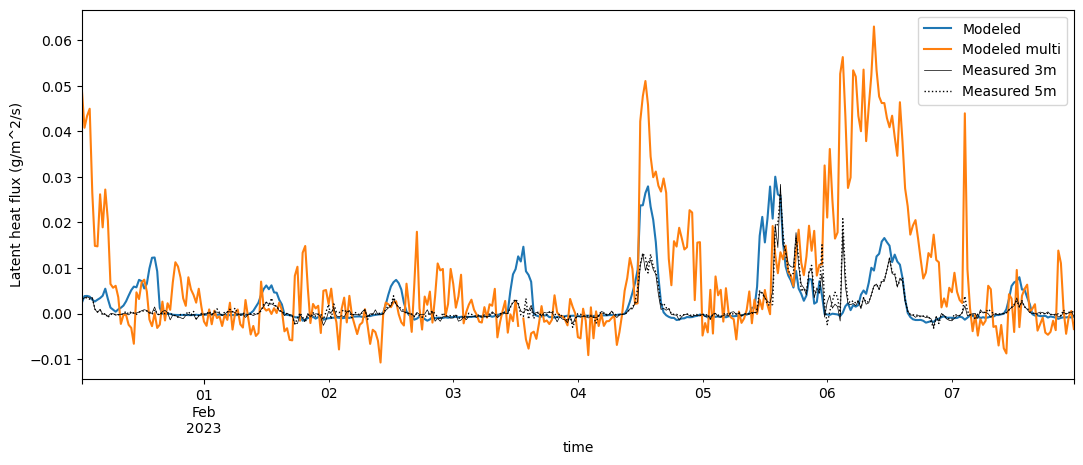

In [22]:
plt.figure(figsize=(2*6.4, 4.8))
src = variables_df[(variables_df.time > "2023-01-31") & (variables_df.time < "2023-02-08")]
src.plot(x='time', y='E_solution', label='Modeled', ax = plt.gca())
src.plot(x='time', y='E_solution_multi', label='Modeled multi', ax = plt.gca())
src.plot(x='time', y='w_h2o__3m_c', label='Measured 3m', color='black', linewidth=0.5, ax = plt.gca())
src.plot(x='time', y='w_h2o__5m_c', label='Measured 5m', color='black', linestyle=':', linewidth=1.0, ax = plt.gca())
# plt.ylim(-0.05, 0.05)
plt.ylabel("Latent heat flux (g/m^2/s)")
plt.legend()

In [23]:
variables_df['specifichumidity_grad'] = (variables_df['specifichumidity_3m_c'] - variables_df['specifichumidity_surface_c']) / 3

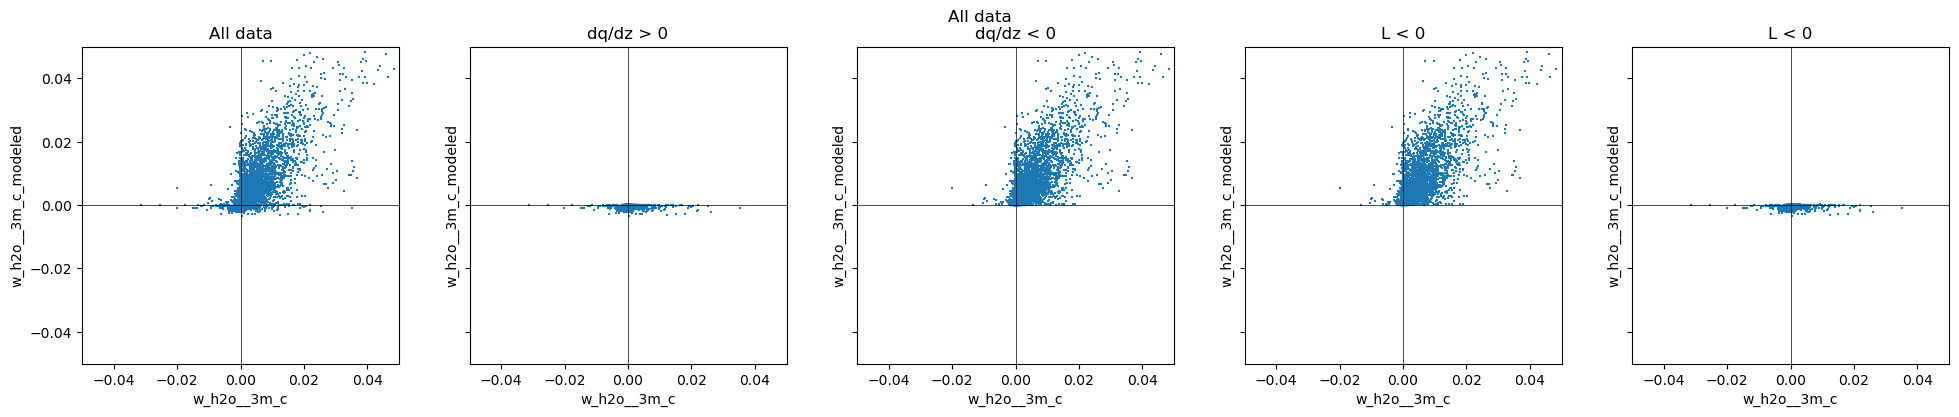

In [24]:
fig, axes = plt.subplots(1,5, figsize=(20,4), sharex=True, sharey=True)

# all data
axes[0].set_title("All data")
axes[0].scatter(variables_df['w_h2o__3m_c'], variables_df['E_solution'], s=0.6, marker='+')

# dq/dz > 0 (expected downward motion of water vapor)
axes[1].set_title("dq/dz > 0")
src = variables_df.query("specifichumidity_grad > 0")
axes[1].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# dq/dz < 0 (expected upward motion of water vapor)
axes[2].set_title("dq/dz < 0")
src = variables_df.query("specifichumidity_grad < 0")
axes[2].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# L < 0
axes[3].set_title("L < 0")
src = variables_df.query("L_solution < 0")
axes[3].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# L > 0
axes[4].set_title("L < 0")
src = variables_df.query("L_solution > 0")
axes[4].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

for ax in axes:
    ax.set_xlabel('w_h2o__3m_c')
    ax.set_ylabel('w_h2o__3m_c_modeled')
    ax.axhline(0, color='k', linewidth=0.5)
    ax.axvline(0, color='k', linewidth=0.5)
    ax.set_xlim(-0.05, 0.05)
    ax.set_ylim(-0.05, 0.05)
    ax.set_aspect('equal')
plt.suptitle("All data")
plt.tight_layout()

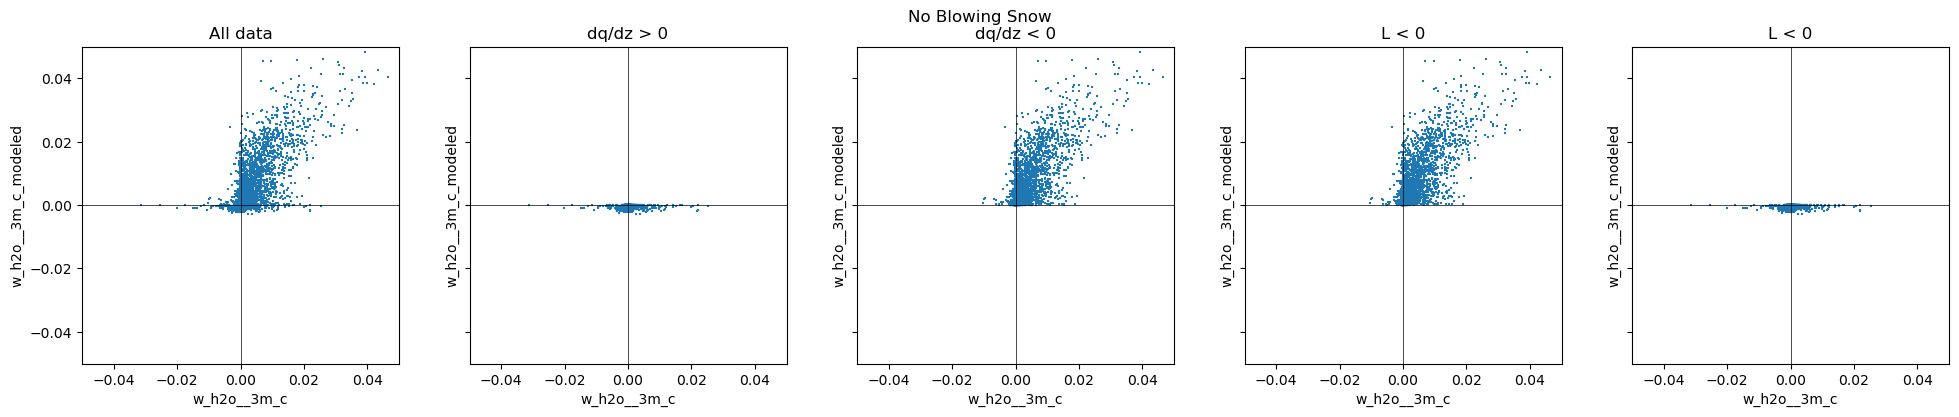

In [25]:
no_bs_times = tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").query("value == 0").time

variables_df_src = variables_df[variables_df.time.isin(no_bs_times)]

fig, axes = plt.subplots(1,5, figsize=(20,4), sharex=True, sharey=True)

# all data
axes[0].set_title("All data")
axes[0].scatter(variables_df_src['w_h2o__3m_c'], variables_df_src['E_solution'], s=0.6, marker='+')

# dq/dz > 0 (expected downward motion of water vapor)
axes[1].set_title("dq/dz > 0")
src = variables_df_src.query("specifichumidity_grad > 0")
axes[1].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# dq/dz < 0 (expected upward motion of water vapor)
axes[2].set_title("dq/dz < 0")
src = variables_df_src.query("specifichumidity_grad < 0")
axes[2].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# L < 0
axes[3].set_title("L < 0")
src = variables_df_src.query("L_solution < 0")
axes[3].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# L > 0
axes[4].set_title("L < 0")
src = variables_df_src.query("L_solution > 0")
axes[4].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

for ax in axes:
    ax.set_xlabel('w_h2o__3m_c')
    ax.set_ylabel('w_h2o__3m_c_modeled')
    ax.axhline(0, color='k', linewidth=0.5)
    ax.axvline(0, color='k', linewidth=0.5)
    ax.set_xlim(-0.05, 0.05)
    ax.set_ylim(-0.05, 0.05)
    ax.set_aspect('equal')
plt.suptitle("No Blowing Snow")
plt.tight_layout()

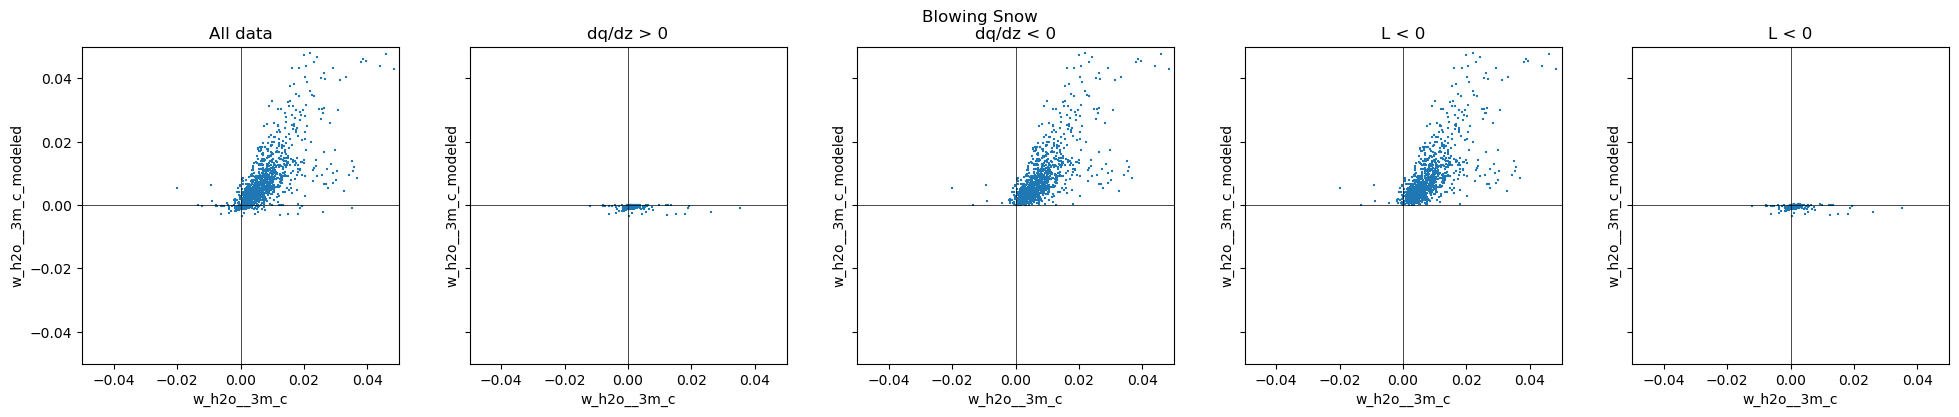

In [26]:
bs_times = tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").query("value > 0").time

variables_df_src = variables_df[variables_df.time.isin(bs_times)]

fig, axes = plt.subplots(1,5, figsize=(20,4), sharex=True, sharey=True)

# all data
axes[0].set_title("All data")
axes[0].scatter(variables_df_src['w_h2o__3m_c'], variables_df_src['E_solution'], s=0.6, marker='+')

# dq/dz > 0 (expected downward motion of water vapor)
axes[1].set_title("dq/dz > 0")
src = variables_df_src.query("specifichumidity_grad > 0")
axes[1].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# dq/dz < 0 (expected upward motion of water vapor)
axes[2].set_title("dq/dz < 0")
src = variables_df_src.query("specifichumidity_grad < 0")
axes[2].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# L < 0
axes[3].set_title("L < 0")
src = variables_df_src.query("L_solution < 0")
axes[3].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# L > 0
axes[4].set_title("L < 0")
src = variables_df_src.query("L_solution > 0")
axes[4].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

for ax in axes:
    ax.set_xlabel('w_h2o__3m_c')
    ax.set_ylabel('w_h2o__3m_c_modeled')
    ax.axhline(0, color='k', linewidth=0.5)
    ax.axvline(0, color='k', linewidth=0.5)
    ax.set_xlim(-0.05, 0.05)
    ax.set_ylim(-0.05, 0.05)
    ax.set_aspect('equal')
plt.suptitle("Blowing Snow")
plt.tight_layout()

# Use TurbPy

In [27]:
from metpy.units import units
import turbpy
import json
import copy

## Get TurbPy parameter schemes

This code for instantiating the TurbPy schemes was copied from the Turbpy example notebook  

https://github.com/klapo/turbpy/blob/master/TF.turbpyDemonstration.ipynb

In [28]:
scheme_dict_1 = {
    'MO (Holtslag/de Bruin)': {
            'stability_method': 'monin_obukhov',
            'monin_obukhov': {
                'gradient_function': 'holtslag_debruin'
            }
        },
    
}
scheme_dict_2 = {
    # 'MO (Webb)': {
    #         'stability_method': 'monin_obukhov',
    #         'monin_obukhov': {
    #             'gradient_function': 'webb'
    #         },
    #         'stability_params': {
    #             'webb': 5.2
    #         }
    # },
    'MO (Webb NoahMP)': {
            'stability_method': 'monin_obukhov',
            'monin_obukhov': {
                'gradient_function': 'webb_noahmp'
            },
            'stability_params': {
                'webb': 5.2
            }
    },
    # 'MO (Marks-Dozier)': {
    #         'stability_method': 'monin_obukhov',
    #         'monin_obukhov': {
    #             'gradient_function': 'marks_dozier'
    #         },
    #         'stability_params': {
    #             'marks_dozier': 5.2
    #         }
    # }
}

## Retrieve our input measurements and convert to units required by TurbPy

In [29]:
SNOW_SURFACE_ROUGHNESS = 1e-4
height = 3
snowDepth = 0
fillna_method='ffill'

# collect inputs
sfcTemp = variables_df['Tsurf_c']
airTemp = variables_df['T_3m_c']
windspd = variables_df['spd_3m_c']
airPressure = (variables_df['P_10m_c'].values * units.millibar).to(units.pascal).magnitude

# the turbpy.vapPress function requires specific humidity in units of g/g
specific_humidity = xr.DataArray(variables_df['specifichumidity_3m_c'])*units('g/kg').to('g/g').magnitude

airVaporPress = turbpy.vapPress(
    specific_humidity,
    airPressure
)

# requires temp in units ˚C
(sfcVaporPress, _) = turbpy.satVapPress(sfcTemp - 273.15)

In [30]:
variables_df[['Tsurf_c',
'T_3m_c',
'spd_3m_c',
'P_10m_c',
'mixingratio_3m_c',]]

variable,Tsurf_c,T_3m_c,spd_3m_c,P_10m_c,mixingratio_3m_c
0,258.074301,260.352508,3.323426,713.159607,0.001308
1,257.587434,260.099139,4.556745,713.428101,0.000996
2,256.968339,259.767198,3.731591,714.011922,0.000960
3,255.153812,258.161803,1.838974,714.681264,0.001019
4,253.760715,256.820924,1.354227,715.163198,0.001059
...,...,...,...,...,...
7977,290.556886,287.060910,4.693956,721.209920,0.004260
7978,288.722728,286.667461,4.374811,721.091563,0.004521
7979,287.810568,286.507073,4.092707,720.957581,0.004395
7980,285.132747,286.142717,4.707404,720.851725,0.004462


## Run the calculations

In [ ]:

## Calculate stability
# Initialzie dictionaries for containing output
stability_correction = {}
conductance_sensible = {}
conductance_latent = {}
sensible_heat = {}
latent_heat = {}
zeta = {}

for scheme in [scheme_dict_1, scheme_dict_2]:
    for stab in scheme.keys():
        stability_correction[stab] = np.zeros_like(sfcTemp)
        conductance_sensible[stab] = np.zeros_like(sfcTemp)
        conductance_latent[stab] = np.zeros_like(sfcTemp)
        sensible_heat[stab] = np.zeros_like(sfcTemp)
        latent_heat[stab] = np.zeros_like(sfcTemp)
        zeta[stab] = np.zeros_like(sfcTemp)

    ## Calculate stability
    for stab in scheme.keys():
        for n, (tair, vpair, tsfc, vpsfc, u, airP) in enumerate(zip(
            airTemp, airVaporPress, sfcTemp, sfcVaporPress, windspd, airPressure
        )):
            if any(np.isnan([tair, vpair, tsfc, vpsfc, u, airP])):
                stability_correction[stab][n] = np.nan
                conductance_sensible[stab][n] = np.nan
                conductance_latent[stab][n] = np.nan
                sensible_heat[stab][n] = np.nan
                latent_heat[stab][n] = np.nan
                zeta[stab][n] = np.nan
            else:
                (
                    conductance_sensible[stab][n], 
                    conductance_latent[stab][n], 
                    sensible_heat[stab][n],
                    latent_heat[stab][n],
                    stab_output,
                    p_test
                ) = turbpy.turbFluxes(tair, airP,
                                                        vpair, u, tsfc,
                                                        vpsfc, snowDepth,
                                                        height, param_dict=scheme[stab],
                                                        z0Ground=SNOW_SURFACE_ROUGHNESS, groundSnowFraction=1)
                # Get the Zeta value from the stability parameters dictionary
                if scheme[stab]['stability_method'] != 'monin_obukhov':
                    stability_correction[stab][n] = stab_output['stabilityCorrection']
                    # SHOULD I JUST BE ASSIGNING NAN HERE?
                    zeta[stab][n] = stab_output['zeta']
                else:
                    stability_correction[stab][n] = np.nan
                    zeta[stab][n] = stab_output['zeta']

## Create dataframe with the Turbpy results, our iterative solution results, and our measurement dataset

In [ ]:
for key in stability_correction.keys():
    variables_df[f'latent_heat_flux {key}'] = -latent_heat[key]/2838
    variables_df[f'sensible_heat_flux {key}'] = -sensible_heat[key]
    variables_df[f'obukhov_length {key}'] = 3 / zeta[key]

In [ ]:
variables_df

## Plot results

In [ ]:
method_names = list(scheme_dict_1.keys()) + list(scheme_dict_2.keys())
method_names

In [ ]:
import itertools
from sklearn.metrics import r2_score

In [ ]:
for (x,y) in list(itertools.combinations(method_names, 2)):
    print(x)
    print(y)
    print(r2_score(variables_df.dropna()[f'latent_heat_flux {x}'],    variables_df.dropna()[f'latent_heat_flux {y}']))
    print()

In [ ]:

src = variables_df[(variables_df.time > '2022-12-24') & (variables_df.time < '2022-12-26')]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(src[['w_h2o__3m_c', 'E_solution']].dropna()['w_h2o__3m_c'], src[['w_h2o__3m_c', 'E_solution']].dropna()[f'E_solution']) 
print("Our solution")
print(r_value**2)
print(np.mean(src['E_solution'] - src['w_h2o__3m_c']))
print()

for x in method_names:
    print(x)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(src[['w_h2o__3m_c', f'latent_heat_flux {x}']].dropna()['w_h2o__3m_c'], src[['w_h2o__3m_c', f'latent_heat_flux {x}']].dropna()[f'latent_heat_flux {x}']) 
    print(r_value**2)
    print(np.mean(src[f'latent_heat_flux {x}'] - src['w_h2o__3m_c']))
    print()

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(src.dropna()['w_h2o__3m_c'], src.dropna()[f'E_solution'])
r_value**2, p_value

In [ ]:
r_value**2, p_value

In [ ]:
variables_df['zeta_solution'] = 3 / variables_df['L_solution']
variables_df['zeta MO (Marks-Dozier)'] = 3 / variables_df['obukhov_length MO (Marks-Dozier)']

In [ ]:
def stability_regime_from_zeta(zeta):
    if np.isnan(zeta):
        return np.nan
    if zeta < -0.01:
        return "unstable"
    elif zeta > -0.01 and zeta < 0.01:
        return "neutral"
    elif zeta > 0.01 and zeta <= 1:
        return "stable"
    elif zeta > 1:
        return "very stable"
    else:
        print("WTF?")
        return np.nan
variables_df['stability regime'] = variables_df['zeta_solution'].apply(stability_regime_from_zeta)
variables_df['stability regime (turbpy)'] = variables_df['zeta MO (Marks-Dozier)'].apply(stability_regime_from_zeta)

In [ ]:
variables_df['end_time'] = variables_df['time'] + dt.timedelta(minutes=30)
unstable_times = variables_df[variables_df['stability regime'] == 'unstable']
neutral_times = variables_df[variables_df['stability regime'] == 'neutral']
stable_times = variables_df[variables_df['stability regime'] == 'stable']
v_stable_times = variables_df[variables_df['stability regime'] == 'very stable']

In [ ]:
plt.scatter(variables_df['zeta MO (Marks-Dozier)'], variables_df['Ri_3m_c'], s=0.1),
plt.axhline(0)
plt.axvline(0)
plt.ylim(-5, 5)
plt.xlim(-50, 50)

In [ ]:
plt.scatter(variables_df['zeta_solution'], variables_df['Ri_3m_c'])

In [ ]:
src = variables_df[(variables_df.time > '2022-12-14') & (variables_df.time < '2022-12-28')]
# src = variables_df
plt.figure(figsize=(12.4, 4.8))
src.plot(x = 'time', y = 'w_h2o__3m_c',                         label = 'Measured',                             color='black',  linewidth=1.0, ax = plt.gca())
src.plot(x = 'time', y = 'E_solution',                          label = 'Iterative MOST (Marks-Dozier)',        color='blue',   linewidth=1.0, ax = plt.gca())
src.plot(x = 'time', y = 'latent_heat_flux MO (Marks-Dozier)',  label = 'TurbPy MOST (Marks-Dozier), β = 5.2',  color='red',  linewidth=1.0, ax = plt.gca())
# src.plot(x = 'time', y = 'latent_heat_flux MO (Webb NoahMP)',   label = 'TurbPy MOST (Webb NoahMP), β = 5.2',   color='red',    linewidth=1.0, ax = plt.gca())
# plt.gca().axhline(0)

for i, row in variables_df.iterrows():
    if row['stability regime'] == 'unstable':
        plt.gca().axvspan(row['time'], row['end_time'], color='yellow', alpha=0.1, label='unstable')
    if row['stability regime'] == 'neutral':
        plt.gca().axvspan(row['time'], row['end_time'], color='grey', alpha=0.2, label='neutral')
    if row['stability regime'] == 'stable':
        plt.gca().axvspan(row['time'], row['end_time'], color='teal', alpha=0.2, label='stable')
    if row['stability regime'] == 'very stable':
        plt.gca().axvspan(row['time'], row['end_time'], color='blue', alpha=0.2, label='very stable')


plt.ylabel("Latent heat fluxes (g/m^2/s)")

In [ ]:
src = variables_df[(variables_df.time > '2022-12-14') & (variables_df.time < '2022-12-28')]
# src = variables_df
plt.figure(figsize=(12.4, 4.8))
src.plot(x = 'time', y = 'w_h2o__3m_c',                         label = 'Measured',                             color='black',  linewidth=1.0, ax = plt.gca())
src.plot(x = 'time', y = 'E_solution',                          label = 'Iterative MOST (Marks-Dozier)',        color='blue',   linewidth=1.0, ax = plt.gca())
src.plot(x = 'time', y = 'latent_heat_flux MO (Marks-Dozier)',  label = 'TurbPy MOST (Marks-Dozier), β = 5.2',  color='red',  linewidth=1.0, ax = plt.gca())
# src.plot(x = 'time', y = 'latent_heat_flux MO (Webb NoahMP)',   label = 'TurbPy MOST (Webb NoahMP), β = 5.2',   color='red',    linewidth=1.0, ax = plt.gca())
# plt.gca().axhline(0)

for i, row in variables_df.iterrows():
    if row['stability regime (turbpy)'] == 'unstable':
        plt.gca().axvspan(row['time'], row['end_time'], color='black', alpha=0.25, label='unstable')
    if row['stability regime (turbpy)'] == 'neutral':
        plt.gca().axvspan(row['time'], row['end_time'], color='darkgrey', alpha=0.75, label='neutral')
    if row['stability regime (turbpy)'] == 'stable':
        plt.gca().axvspan(row['time'], row['end_time'], color='lightgrey', alpha=0.5, label='stable')
    if row['stability regime (turbpy)'] == 'very stable':
        plt.gca().axvspan(row['time'], row['end_time'], color='white', alpha=0.5, label='very stable')


plt.ylabel("Latent heat fluxes (g/m^2/s)")

In [ ]:
src = variables_df[(variables_df.time > '2022-12-14') & (variables_df.time < '2022-12-28')]
# src = variables_df
plt.figure(figsize=(12.4, 4.8))
src.plot(x = 'time', y = 'w_tc__3m_c',                         label = 'Measured',                             color='black',  linewidth=1.0, ax = plt.gca())
src.plot(x = 'time', y = 'H_solution',                          label = 'Iterative MOST (Marks-Dozier)',        color='blue',   linewidth=1.0, ax = plt.gca())
src.plot(x = 'time', y = 'sensible_heat_flux MO (Marks-Dozier)',  label = 'TurbPy MOST (Marks-Dozier), β = 5.2',  color='red',  linewidth=1.0, ax = plt.gca())
# src.plot(x = 'time', y = 'latent_heat_flux MO (Webb NoahMP)',   label = 'TurbPy MOST (Webb NoahMP), β = 5.2',   color='red',    linewidth=1.0, ax = plt.gca())
# plt.gca().axhline(0)

for i, row in variables_df.iterrows():
    if row['stability regime (turbpy)'] == 'unstable':
        plt.gca().axvspan(row['time'], row['end_time'], color='black', alpha=0.25, label='unstable')
    if row['stability regime (turbpy)'] == 'neutral':
        plt.gca().axvspan(row['time'], row['end_time'], color='darkgrey', alpha=0.75, label='neutral')
    if row['stability regime (turbpy)'] == 'stable':
        plt.gca().axvspan(row['time'], row['end_time'], color='lightgrey', alpha=0.5, label='stable')
    if row['stability regime (turbpy)'] == 'very stable':
        plt.gca().axvspan(row['time'], row['end_time'], color='white', alpha=0.5, label='very stable')


plt.ylabel("Sensible heat fluxes (W/m^2)")

In [ ]:
src = variables_df[(variables_df.time > '2022-12-14') & (variables_df.time < '2022-12-28')]



# src = variables_df
plt.figure(figsize=(12.4, 4.8))
src.plot(x = 'time', y = 'zeta_solution',                          label = 'Iterative MOST (Marks-Dozier)',        color='blue',   linewidth=1.0, ax = plt.gca())
src.plot(x = 'time', y = 'zeta MO (Marks-Dozier)',  label = 'TurbPy MOST (Marks-Dozier), β = 5.2',  color='red',  linewidth=1.0, ax = plt.gca())
# src.plot(x = 'time', y = 'latent_heat_flux MO (Webb NoahMP)',   label = 'TurbPy MOST (Webb NoahMP), β = 5.2',   color='red',    linewidth=1.0, ax = plt.gca())
# plt.gca().axhline(0)
plt.ylabel("Obukhov length")
# plt.ylim(-250,250)
plt.yscale('symlog')

plt.axhline(0)
plt.axhline(1)
plt.axhline(-1)